In [ ]:
'''
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d salader/dogs-vs-cats

import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
'''

In [ ]:
pip install -q geopandas

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 46.5 MB/s 
     |████████████████████████████████| 6.3 MB 32.9 MB/s 


In [ ]:
pip install -q shap

     |████████████████████████████████| 569 kB 6.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
warnings.simplefilter("ignore")
plt.style.use("bmh")
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import shap
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/conference/indian_new.csv")

In [ ]:
df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4N,87.0E,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7N,86.5E,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9N,86.3E,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9N,86.3E,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9N,86.3E,35,CS,996,7


In [ ]:
df["Time"] = df["Time"].astype("object")
time_replace = [str(x) for x in df["Time"].unique()]

for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, "0")
    time_replace[i] = f"{time_replace[i][0:2]}:{time_replace[i][2:4]}:00"
        
for old, new in zip(df["Time"].unique(), time_replace):
    df.loc[df["Time"]==old, "Time"] = new

In [ ]:
df["Date"] = df["Date"].astype("object")
for i, date_str in enumerate(df["Date"].unique()):
    df.loc[df["Date"] == date_str, "Date"] = f"{str(date_str)[0:4]} - {str(date_str)[4:6]} - {str(date_str)[6:]}"

In [ ]:
df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,2020 - 05 - 16,00:00:00,10.4N,87.0E,25,D,1000,3
1,A1,AMPHAN,2020 - 05 - 16,03:00:00,10.7N,86.5E,25,D,1000,3
2,A1,AMPHAN,2020 - 05 - 16,06:00:00,10.9N,86.3E,25,D,1000,3
3,A1,AMPHAN,2020 - 05 - 16,09:00:00,10.9N,86.3E,30,DD,998,5
4,A1,AMPHAN,2020 - 05 - 16,12:00:00,10.9N,86.3E,35,CS,996,7


In [ ]:
df["Datetime"] = df["Date"]+ " " + df["Time"]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.drop(columns = ["Date", "Time"], inplace = True)
df.sort_values(by = ["Datetime"], inplace = True)

In [ ]:
df["Name"] = df["Name"].str.strip()

In [ ]:
print(f"Dataset contains data of {df['ID'].unique().shape[0]} individual storms from {df['Datetime'].dt.year.min()} to {df['Datetime'].dt.year.max()}.")

Dataset contains data of 97 individual storms from 2001 to 2020.


In [ ]:
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1] == "W":
        coord *= -1
    if x[-1] == "S":
        coord *= -1
    return coord

In [ ]:
df["Latitude"] = df["Latitude"].apply(coordinate_mapping)
df["Longitude"] = df["Longitude"].apply(coordinate_mapping)

In [ ]:
print("Min. Long.:", df.Longitude.min(), "Max. Long.:", df.Longitude.max(), "Min. Lat.:", df.Latitude.min(), "Max. Lat.:", df.Latitude.max())

Min. Long.: 42.9 Max. Long.: 99.7 Min. Lat.: 1.5 Max. Lat.: 27.0


In [ ]:
df.loc[df.Longitude < -180, "Longitude"] = df.Longitude + 360

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude), crs = {'init' :'epsg:4326'})

In [ ]:
gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

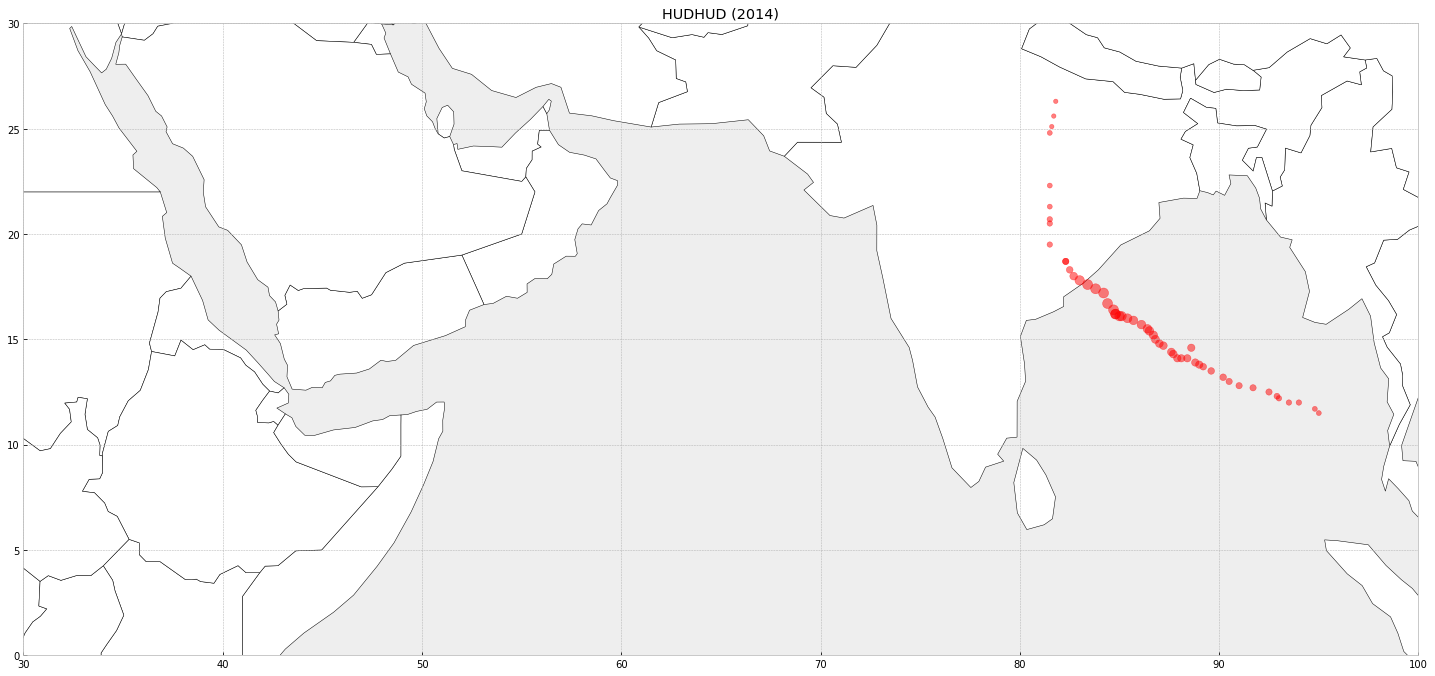

In [ ]:
ax = world.plot(color = "white", edgecolor = "black", figsize = (25, 12))
_ = gdf[gdf["ID"] == "G3"].plot(ax = ax, c = "r", markersize = "Maximum Wind", alpha = 0.5)
_ = plt.xlim(30, 100)
_ = plt.ylim(0, 30)
_ = plt.title(f'{gdf[gdf["ID"] == "G3"].Name.unique()[0]} ({gdf[gdf["ID"] == "G3"].Datetime.dt.year.unique()[0]})')

To make predictions i'll construct a simplified coordinate system where the latitude is the x axis and longitude is the y axis and the positions of all storms are between 0 and 1.

In [ ]:
lat_min = gdf.Latitude.min()
long_min = gdf.Longitude.min()
gdf["x"] = gdf.Latitude - lat_min
gdf["x"] = gdf["x"]/gdf["x"].max()
gdf["y"] = gdf.Longitude - long_min
gdf["y"] = gdf["y"]/gdf["y"].max()

The month and season is an important feature because this contains implicit information such as the water temperature. A continous number is much easier to work with than with months/days etc. so i'll create a feature where the first of january corresponds to 0 and the 31th of december corresponds to 1.
Additionally i'll create a feature "Month of year" and "Hour of day".

In [ ]:
gdf["relative_time"] = ((gdf.Datetime.dt.dayofyear+(gdf.Datetime.dt.hour/24.)+(gdf.Datetime.dt.minute/60.*24))/366.) 
# Each day is 1/366 of a year (WITH 31th of december), 
# each hour is a 1/24 of a day and each minute 1/60 of a hour.

In [ ]:
gdf["month"] = gdf.Datetime.dt.month
gdf["hour"] = gdf.Datetime.dt.hour

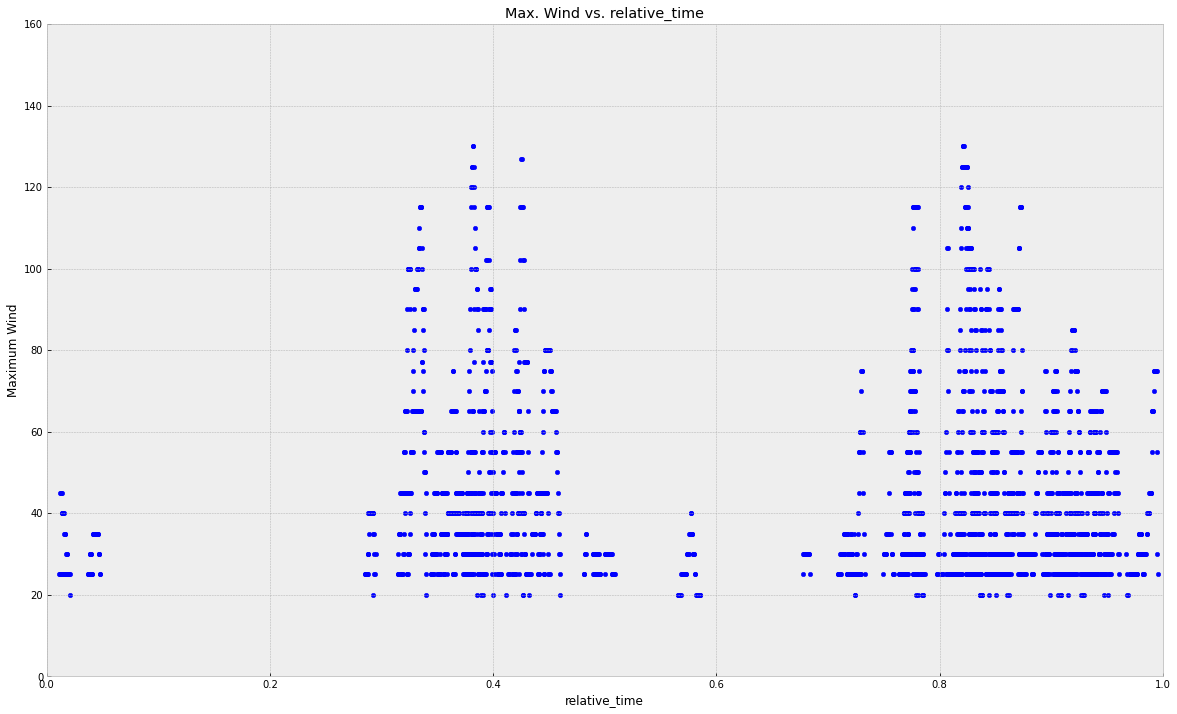

In [ ]:
_ = gdf.plot(x = "relative_time", y = "Maximum Wind", kind = "scatter", figsize = (20,12), title = "Max. Wind vs. relative_time")
_ = plt.ylim(0, 160)
_ = plt.xlim(0, 1)

We'll try to predict the next position in the storm trajectory. To be able to do this we need to calculate the vectors for each positional change.

In [ ]:
gdf["vec_x"] = np.nan
gdf["vec_y"] = np.nan
vecs = {"x": [], "y": [], "id": []}
for storm_id in gdf["ID"].unique():
    last_x = 0
    last_y = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_x == 0:
            last_x = row.x
            last_y = row.y
        else:
            vec_x = row.x - last_x
            vec_y = row.y - last_y
            vecs["x"].append(vec_x)
            vecs["y"].append(vec_y)
            vecs["id"].append(i)
            last_x = row.x
            last_y = row.y
            
gdf.loc[vecs["id"], "vec_x"] = vecs["x"]
gdf.loc[vecs["id"], "vec_y"] = vecs["y"]

Because we can only predict one value we'll need two models to predict the trajectory. As the independent prediction of the x and y position probably won't work i'll use one model to predict the change in direction (angle) and the change in distance (length).

In [ ]:
gdf["vec_len"] = np.sqrt((gdf["vec_x"]**2) + (gdf["vec_y"]**2))

In [ ]:
gdf.head()

,ID,Name,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Datetime,geometry,x,y,relative_time,month,hour,vec_x,vec_y,vec_len
2905,T1,01A,13.5,69.0,25,D,1000,4,2001-05-21 12:00:00,POINT (69.00000 13.50000),0.470588,0.459507,0.386612,5,12,NaN,NaN,NaN
2906,T1,01A,13.5,70.0,25,D,1000,4,2001-05-21 18:00:00,POINT (70.00000 13.50000),0.470588,0.477113,0.387295,5,18,0.000000,0.017606,0.017606
2907,T1,01A,13.5,70.0,30,DD,998,6,2001-05-21 21:00:00,POINT (70.00000 13.50000),0.470588,0.477113,0.387637,5,21,0.000000,0.000000,0.000000
2908,T1,01A,14.0,71.0,30,DD,998,6,2001-05-22 00:00:00,POINT (71.00000 14.00000),0.490196,0.494718,0.387978,5,0,0.019608,0.017606,0.026352
2909,T1,01A,14.0,71.5,40,CS,996,8,2001-05-22 03:00:00,POINT (71.50000 14.00000),0.490196,0.503521,0.388320,5,3,0.000000,0.008803,0.008803


In [ ]:
def calculate_direction(vec_x, vec_y):
    def vec_angle(a, b):
        return np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))
    
    ref_vec = np.array([vec_x, vec_y])
    N_vec = np.array([0,1])
    S_vec = np.array([0,-1])
    E_vec = np.array([1,0])
    W_vec = np.array([-1,0])
    N_angle = vec_angle(ref_vec, N_vec)
    E_angle = vec_angle(ref_vec, E_vec)
    W_angle = vec_angle(ref_vec, W_vec)
    return_angle = N_angle
    
    if W_angle < E_angle:
        return_angle = 2*np.pi - return_angle
    return return_angle

In [ ]:
gdf["vec_direction"] = gdf.apply(lambda x: calculate_direction(x.vec_x, x.vec_y), axis = 1)

In [ ]:
gdf["tdelta"] = np.nan
tdeltas = {"t": [], "id": []}

for storm_id in gdf["ID"].unique():
    last_time = 0
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_time==0:
            last_time = row.Datetime
        else:
            tdeltas["t"].append((row.Datetime-last_time).seconds)
            tdeltas["id"].append(i)
            last_time = row.Datetime
gdf.loc[tdeltas["id"], "tdelta"] = tdeltas["t"]

In [ ]:
gdf.head()

,ID,Name,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Datetime,geometry,x,y,relative_time,month,hour,vec_x,vec_y,vec_len,vec_direction,tdelta
2905,T1,01A,13.5,69.0,25,D,1000,4,2001-05-21 12:00:00,POINT (69.00000 13.50000),0.470588,0.459507,0.386612,5,12,NaN,NaN,NaN,NaN,NaN
2906,T1,01A,13.5,70.0,25,D,1000,4,2001-05-21 18:00:00,POINT (70.00000 13.50000),0.470588,0.477113,0.387295,5,18,0.000000,0.017606,0.017606,0.00000,21600.0
2907,T1,01A,13.5,70.0,30,DD,998,6,2001-05-21 21:00:00,POINT (70.00000 13.50000),0.470588,0.477113,0.387637,5,21,0.000000,0.000000,0.000000,NaN,10800.0
2908,T1,01A,14.0,71.0,30,DD,998,6,2001-05-22 00:00:00,POINT (71.00000 14.00000),0.490196,0.494718,0.387978,5,0,0.019608,0.017606,0.026352,0.83915,10800.0
2909,T1,01A,14.0,71.5,40,CS,996,8,2001-05-22 03:00:00,POINT (71.50000 14.00000),0.490196,0.503521,0.388320,5,3,0.000000,0.008803,0.008803,0.00000,10800.0


In [ ]:
#gdf = gdf[gdf["tdelta"] == 21600]
gdf = gdf[gdf["tdelta"] == 21600]
gdf.shape

(402, 20)

In [ ]:
gdf["prev_len"] = np.nan
gdf["prev_direction"] = np.nan
prevs = {"len": [], "direction": [], "id": []}

for storm_id in gdf["ID"].unique():
    last_len = False
    last_direction = False
    for i, row in gdf[gdf["ID"]==storm_id].iterrows():
        if last_len == False:
            last_len = row.vec_len
            last_direction = row.vec_direction
        else:
            prevs["len"].append(last_len)
            prevs["direction"].append(last_direction)
            prevs["id"].append(i)
            last_len = row.vec_len
            last_direction = row.vec_direction
            
gdf.loc[prevs["id"], "prev_len"] = prevs["len"]
gdf.loc[prevs["id"], "prev_direction"] = prevs["direction"]

In [ ]:
gdf.dropna(how = "any", inplace = True)
gdf.shape

(257, 22)

## Prediction

Model

The hypothesis for both models (distance traveled, direction) depends on the following features:

1. Maximum Wind: The highest measured windspeed
2. Position (x, y): Probably the most important feature, as storms behave similary in the gulf etc. (my hope is, that the models create some kind of artifical grid, e.g. if x>0.1 and x<0.2 etc., even though that requires A LOT of splits)
3. Month of year: A latent variable for the genereal climatic conditions (Temperature, Jet stream etc.)
4. Hour of day: A latent variable for temperature (usually the temperature at 12am is different than at 2am etc.)
5. Previous distance/direction

In [ ]:
gdf_prediction_direction = gdf[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction", "vec_direction"]]
gdf_prediction_length = gdf[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction", "vec_len"]]
X_direction = gdf_prediction_direction.values[:,:-1]
y_direction = gdf_prediction_direction.values[:,-1]
X_length = gdf_prediction_length.values[:,:-1]
y_length = gdf_prediction_length.values[:,-1]

In [ ]:
X_direction_train, X_direction_test, y_direction_train, y_direction_test = train_test_split(X_direction, y_direction, test_size = 0.2)
X_length_train, X_length_test, y_length_train, y_length_test = train_test_split(X_length, y_length, test_size = 0.2)

In [ ]:
model_direction = GradientBoostingRegressor(n_estimators = 100, 
                                            learning_rate = 0.01, 
                                            max_depth = 8, 
                                            random_state = 0, 
                                            loss = 'ls').fit(X_direction_train, y_direction_train)
mean_squared_error(y_direction_test, model_direction.predict(X_direction_test))

0.801966003985476

error in degrees = mean_squared_error * 180 / pi

In [ ]:
model_length = GradientBoostingRegressor(n_estimators = 100, 
                                         learning_rate = 0.01, 
                                         max_depth = 8, 
                                         random_state = 0, 
                                         loss = 'ls').fit(X_length_train, y_length_train)
mean_squared_error(y_length_test, model_length.predict(X_length_test))

0.0001333488460820359

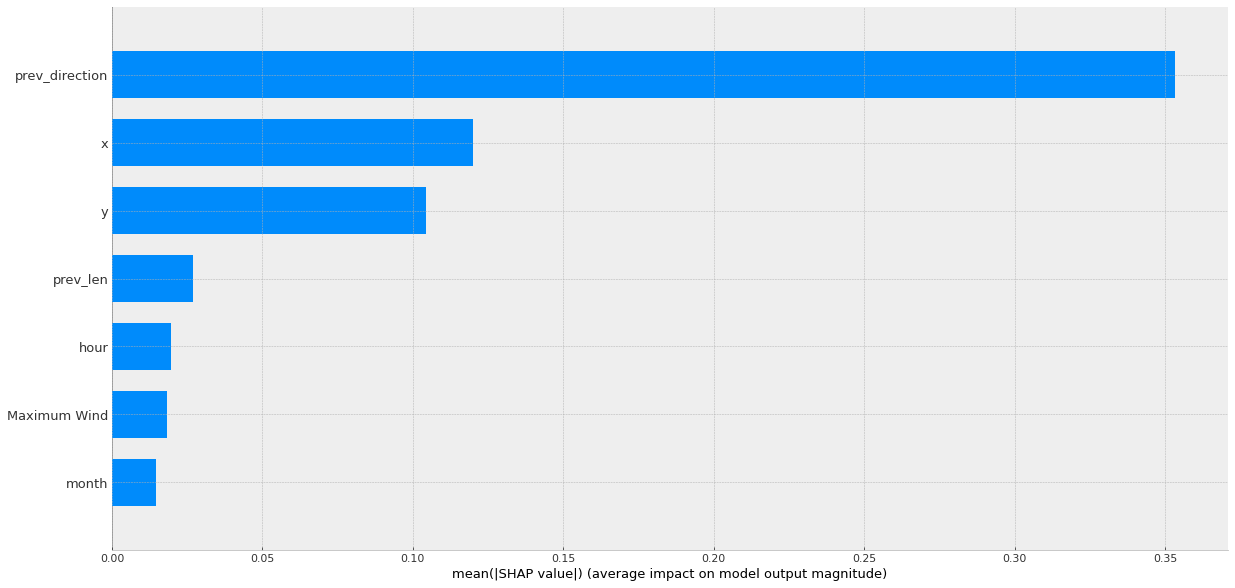

In [ ]:
explainer_direction = shap.TreeExplainer(model_direction)
shap_values_direction = explainer_direction.shap_values(X_direction_test)
shap.summary_plot(shap_values_direction, 
                  X_direction_test, 
                  plot_type = "bar", 
                  feature_names = ["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"], 
                  title = "Feature importances model_direction", 
                  plot_size = (20,10))

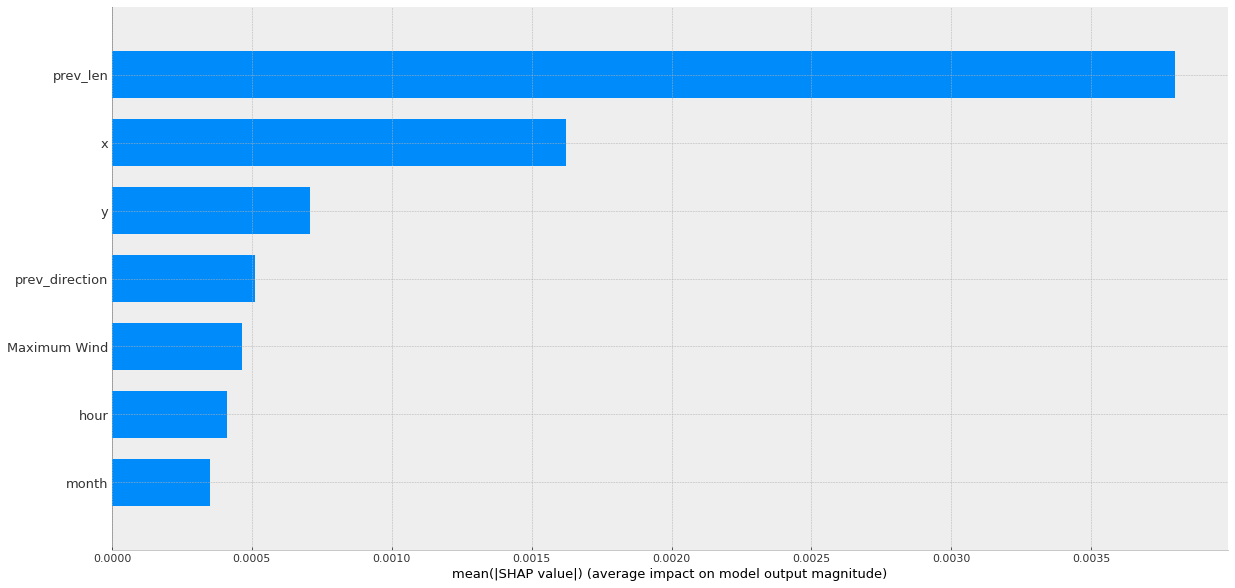

In [ ]:
explainer_length = shap.TreeExplainer(model_length)
shap_values_length = explainer_length.shap_values(X_length_test)
shap.summary_plot(shap_values_length, 
                  X_length_test, 
                  plot_type = "bar", 
                  feature_names = ["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"], 
                  title = "Feature importances model_length", 
                  plot_size = (20,10))

## Results

i'll predict the trajectory of a storm and plot the real (red) and predicted (blue) trajectories in the same plot.
This involves some rather complicated transformations, similar to the calculation of the features above (only in the opposite direction)


In [ ]:
lat_min = df.Latitude.min()
long_min = df.Longitude.min()
temp_x = df.Latitude - lat_min
temp_y = df.Longitude - long_min
x_max = temp_x.max()
y_max = temp_y.max()

def coords_to_latlong(x, y, lat_min, long_min, x_max, y_max):
    return (x*x_max) + lat_min, (y*y_max) + long_min

In [ ]:
gdf[gdf.Name == "G3"].ID.unique()

array([], dtype=object)

In [ ]:
storm_id = "G3"
gdf_pred = gdf[["Latitude", "Longitude", "Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction", "vec_len", "vec_direction"]][gdf.ID == storm_id]
X_pred_direction = gdf_pred[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"]].iloc[1:].values
X_pred_len = gdf_pred[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"]].iloc[1:].values

In [ ]:
df_pred = pd.DataFrame({"pred_len": model_length.predict(X_pred_len), 
                        "pred_direction": model_direction.predict(X_pred_direction)})

In [ ]:
df_pred["pred_x"] = np.nan
df_pred["pred_y"] = np.nan
df_pred["real_x"] = gdf_pred["x"].iloc[1:].values
df_pred["real_y"] = gdf_pred["y"].iloc[1:].values

In [ ]:
last_x = gdf_pred["x"].iloc[0]
last_y = gdf_pred["y"].iloc[0]
coords = {"x": [], "y": [], "id": []}

for i, row in df_pred.iterrows():
    vector = np.array([0,1])
    R = np.array([[np.cos(row.pred_direction), -np.sin(row.pred_direction)], 
                  [np.sin(row.pred_direction), np.cos(row.pred_direction)]])
    vector = np.matmul(vector, R)
    vector = vector/np.linalg.norm(vector)
    vector *= row.pred_len
    coords["x"].append(last_x+vector[0])
    coords["y"].append(last_y+vector[1])
    coords["id"].append(i)
    last_x = row.real_x
    last_y = row.real_y
    
df_pred.loc[coords["id"], "pred_x"] = coords["x"]
df_pred.loc[coords["id"], "pred_y"] = coords["y"]

In [ ]:
df_pred["pred_Longitude"] = np.nan
df_pred["real_Longitude"] = np.nan
df_pred["pred_Latitude"] = np.nan
df_pred["real_Latitude"] = np.nan
latslongs = {"pred_Longitude": [], "real_Longitude": [], "pred_Latitude": [], "real_Latitude": [], "id": []}

for i, row in df_pred.iterrows():
    real_Latitude, real_Longitude = coords_to_latlong(row.real_x, row.real_y, lat_min, long_min, x_max, y_max)
    latslongs["real_Latitude"].append(real_Latitude)
    latslongs["real_Longitude"].append(real_Longitude)
    pred_Latitude, pred_Longitude = coords_to_latlong(row.pred_x, row.pred_y, lat_min, long_min, x_max, y_max)
    latslongs["pred_Latitude"].append(pred_Latitude)
    latslongs["pred_Longitude"].append(pred_Longitude)
    latslongs["id"].append(i)
    
df_pred.loc[latslongs["id"], "real_Latitude"] = latslongs["real_Latitude"]
df_pred.loc[latslongs["id"], "real_Longitude"] = latslongs["real_Longitude"]
df_pred.loc[latslongs["id"], "pred_Latitude"] = latslongs["pred_Latitude"]
df_pred.loc[latslongs["id"], "pred_Longitude"] = latslongs["pred_Longitude"]

In [ ]:
df_pred.head(100)

,pred_len,pred_direction,pred_x,pred_y,real_x,real_y,pred_Longitude,real_Longitude,pred_Latitude,real_Latitude
0,0.014320,1.943173,0.396055,0.885635,0.390947,0.882042,93.204068,93.0,12.324128,12.2
1,0.022333,1.776961,0.412806,0.877471,0.765432,0.679577,92.740329,81.5,12.731192,21.3
2,0.029804,1.876846,0.793851,0.670598,0.806584,0.679577,80.989956,81.5,21.990573,22.3
3,0.071902,1.806351,0.876501,0.662797,0.909465,0.679577,80.546856,81.5,23.998974,24.8


In [ ]:
gdf_real = gpd.GeoDataFrame(df_pred, geometry = gpd.points_from_xy(df_pred.real_Longitude,df_pred.real_Latitude), 
                            crs = {'init' :'epsg:4326'})
gdf_pred = gpd.GeoDataFrame(df_pred, geometry = gpd.points_from_xy(df_pred.pred_Longitude,df_pred.pred_Latitude), 
                            crs = {'init' :'epsg:4326'})

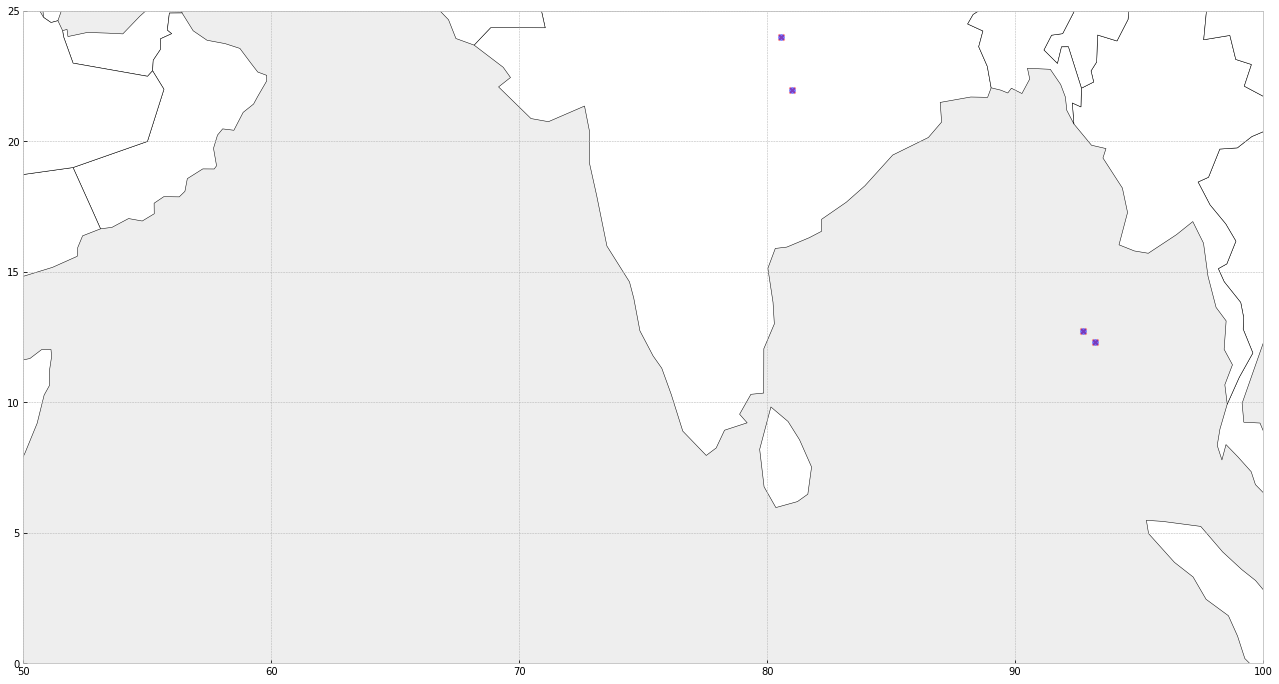

In [ ]:
ax = world.plot(color = "white", edgecolor = "black", figsize = (25, 12))
_ = gdf_real.plot(ax = ax, c = "r", marker = "x", alpha = 0.5)
_ = gdf_pred.plot(ax = ax, c = "b", marker = "o", alpha = 0.5)
_ = plt.xlim(50, 100)
_ = plt.ylim(0, 25)

## Cyclone Heatmap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import os

In [ ]:
indianDF = pd.read_csv("/content/drive/MyDrive/conference/indian_new.csv")
indianDF = indianDF[["Latitude", "Longitude"]]

In [ ]:
indianDF.head()

,Latitude,Longitude
0,10.4N,87.0E
1,10.7N,86.5E
2,10.9N,86.3E
3,10.9N,86.3E
4,10.9N,86.3E


In [ ]:
map_van = folium.Map(location = [28.6139, 77.2090], zoom_start = 5)

In [ ]:
indianDF = indianDF.replace({'N':''}, regex=True)
indianDF = indianDF.replace({'W':''}, regex=True)
indianDF = indianDF.replace({'E':''}, regex=True)
indianDF = indianDF.replace({'S':''}, regex=True)

In [ ]:
indianDF.head()

,Latitude,Longitude
0,10.4,87.0
1,10.7,86.5
2,10.9,86.3
3,10.9,86.3
4,10.9,86.3


In [ ]:
HeatMap(indianDF).add_to(map_van)

In [ ]:
map_van

## Analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 
import plotly.express as px
import os

In [ ]:
indian_hurricanes = pd.read_csv('/content/drive/MyDrive/conference/indian_new.csv')
indian_hurricanes.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4N,87.0E,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7N,86.5E,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9N,86.3E,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9N,86.3E,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9N,86.3E,35,CS,996,7


In [ ]:
df = pd.DataFrame(indian_hurricanes)
df.shape

(2965, 10)

In [ ]:
booleans = []
# filter cyclone from 2000
for date in df['Date']:
    if date > 20000000:
        booleans.append(True)
    else: 
        booleans.append(False)
        
date_range = pd.Series(booleans)
new_df = df[date_range]

new_df.shape
new_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4N,87.0E,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7N,86.5E,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9N,86.3E,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9N,86.3E,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9N,86.3E,35,CS,996,7


In [ ]:
#drop unnecessary titles
new_df.drop(['ID', 'Time' ,'Name'], axis = 1)

,Date,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,20200516,10.4N,87.0E,25,D,1000,3
1,20200516,10.7N,86.5E,25,D,1000,3
2,20200516,10.9N,86.3E,25,D,1000,3
3,20200516,10.9N,86.3E,30,DD,998,5
4,20200516,10.9N,86.3E,35,CS,996,7
...,...,...,...,...,...,...,...
2960,20010528,21.0N,68.5E,30,DD,996,6
2961,20010528,21.0N,68.5E,30,DD,996,6
2962,20010528,21.5N,69.0E,25,D,998,4
2963,20010528,21.5N,69.0E,25,D,998,4


In [ ]:
#removing Hemisphere tags from coordiantes:
new_df['Longitude'] = new_df['Longitude'].map(lambda x: x.rstrip('W'))
new_df['Latitude'] = new_df['Latitude'].map(lambda x: x.rstrip('N'))
new_df['Latitude'] = new_df['Latitude'].map(lambda x: x.rstrip('S'))
new_df['Longitude'] = new_df['Longitude'].map(lambda x: x.rstrip('E'))

In [ ]:
new_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4,87.0,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7,86.5,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9,86.3,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9,86.3,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9,86.3,35,CS,996,7


In [ ]:
#converting Latitude and Longitude to floats:
new_df['Latitude'] = new_df['Latitude'].astype(float)
new_df['Longitude'] = new_df['Longitude'].astype(float)

In [ ]:
#filtering outside latitudes
lat_filtered_df = new_df[(new_df['Latitude'].astype(float) >= float(-30)) & (new_df['Latitude'].astype(float) <= float(30))]

print(lat_filtered_df.shape)

#filtering out longitude by coordinate, convert longitude to negative
#lat_filtered_df['Longitude'] = (lat_filtered_df['Longitude'] * -1)
lat_long_filtered_df = lat_filtered_df[(lat_filtered_df['Longitude'] >= 40) & (lat_filtered_df['Longitude'] <= float(100))]
print(lat_long_filtered_df.shape)

#from the clearly reduced row numbers, it is clear to see that filter has worked

(2965, 10)
(2965, 10)


In [ ]:
#Converting all data to strings so can be searched
all_columns = list(lat_long_filtered_df) # Creates list of all column headers
lat_long_filtered_df[all_columns] = lat_long_filtered_df[all_columns].astype(str)

#Converting all '-999' null values to 'NaN' which Python can automatically remove:
lat_long_filtered_df = lat_long_filtered_df.replace('-999', np.nan)

#the year 1967 has '-99' as maximum wind speed values - these must also be changed
lat_long_filtered_df = lat_long_filtered_df.replace('-99', np.nan)
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop
0,A1,AMPHAN,20200516,0,10.4,87.0,25,D,1000,3
1,A1,AMPHAN,20200516,300,10.7,86.5,25,D,1000,3
2,A1,AMPHAN,20200516,600,10.9,86.3,25,D,1000,3
3,A1,AMPHAN,20200516,900,10.9,86.3,30,DD,998,5
4,A1,AMPHAN,20200516,1200,10.9,86.3,35,CS,996,7


In [ ]:
#Changing date format:
import datetime as t
#df['DateTime'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')

lat_long_filtered_df['Date'] = pd.to_datetime(lat_long_filtered_df['Date'].astype(str), format = '%Y %m %d')
lat_long_filtered_df

#adding year column
lat_long_filtered_df['Year'] = lat_long_filtered_df['Date'].map(lambda x: x.year)
lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year
0,A1,AMPHAN,2020-05-16,0,10.4,87.0,25,D,1000,3,2020
1,A1,AMPHAN,2020-05-16,300,10.7,86.5,25,D,1000,3,2020
2,A1,AMPHAN,2020-05-16,600,10.9,86.3,25,D,1000,3,2020
3,A1,AMPHAN,2020-05-16,900,10.9,86.3,30,DD,998,5,2020
4,A1,AMPHAN,2020-05-16,1200,10.9,86.3,35,CS,996,7,2020


In [ ]:
#checking for negative values
negatives =[]
for i in lat_long_filtered_df['Maximum Wind']:
    if float(i) < 0:
        negatives.append(i)
        
print(negatives)

[]


In [ ]:
#dropping duplicate storms
#lat_long_filtered_df = lat_long_filtered_df.sort_values(by = 'Maximum Wind', ascending = False)
#lat_long_filtered_df = lat_long_filtered_df.drop_duplicates(subset = 'Name', keep = "first")

#resort by year
lat_long_filtered_df = lat_long_filtered_df.sort_values(by ='Year', ascending = True)
lat_long_filtered_df.shape

lat_long_filtered_df.head()

,ID,Name,Date,Time,Latitude,Longitude,Maximum Wind,Status,Estimated Central Pressure,Pressure Drop,Year
2964,T1,01A,2001-05-29,0,21.5,69.0,25,D,998,4,2001
2934,T1,01A,2001-05-25,600,17.0,68.0,90,ESCS,960,40,2001
2962,T1,01A,2001-05-28,1800,21.5,69.0,25,D,998,4,2001
2960,T1,01A,2001-05-28,1200,21.0,68.5,30,DD,996,6,2001
2959,T1,01A,2001-05-28,900,20.0,68.0,35,CS,996,8,2001


In [ ]:
#creating dataframe of number of storms per year
number_of_storms={}

count = lat_long_filtered_df['Year'].value_counts()
count_df = pd.DataFrame(count)
count_df = count_df.reset_index()

count_df = count_df.rename(columns={"index": "Year", "Year": "Count"})

count_df = count_df.sort_values(by = "Year", ascending = True)
count_df

,Year,Count
18,2001,60
17,2002,104
10,2003,123
13,2004,115
8,2005,136
16,2006,106
9,2007,126
12,2008,117
15,2009,106
4,2010,159


In [ ]:
#create averages
lat_long_filtered_df['Maximum Wind'] = lat_long_filtered_df['Maximum Wind'].astype(float)
lat_long_filtered_df.Year = lat_long_filtered_df.Year.astype(int)

grouped_df = lat_long_filtered_df.groupby(['Year'])
described_df = grouped_df.describe()
described_df = described_df.reset_index()
described_df = pd.DataFrame(described_df)

described_df.columns = ['Year', 'Count', "Mean", 'std', 'min', '25%', '50%', '75%', 'Max']

described_df

,Year,Count,Mean,std,min,25%,50%,75%,Max
0,2001,60.0,63.016667,28.771744,25.0,35.00,55.0,90.00,115.0
1,2002,104.0,31.346154,6.002862,25.0,25.00,30.0,35.00,55.0
2,2003,123.0,42.032520,13.334250,25.0,30.00,35.0,55.00,75.0
3,2004,115.0,41.365217,12.195290,25.0,30.00,45.0,45.00,90.0
4,2005,136.0,33.750000,6.824520,20.0,30.00,35.0,35.00,45.0
5,2006,106.0,38.207547,21.438602,25.0,25.00,30.0,42.50,100.0
6,2007,126.0,57.976190,31.498435,25.0,30.00,45.0,90.00,127.0
7,2008,117.0,43.239316,18.107747,20.0,30.00,35.0,65.00,90.0
8,2009,106.0,33.018868,7.611997,20.0,26.25,30.0,40.00,60.0
9,2010,159.0,44.371069,17.778010,20.0,30.00,40.0,55.00,105.0


In [ ]:
#adding month column to new dataframe
month_df = lat_long_filtered_df
month_df = month_df.drop(['Year'], axis = 1)

month_df['Month'] = month_df['Date'].map(lambda x: x.month)

In [ ]:
#group by month
month_df['Maximum Wind'] = month_df['Maximum Wind'].astype(float)
month_df.Month = month_df.Month.astype(int)

grouped_df_month = month_df.groupby(['Month'])

described_df_month = grouped_df_month.describe()

described_df_month = described_df_month.reset_index()


described_df_month= pd.DataFrame(described_df_month)

described_df_month.columns = ['Month', 'Count', "Mean", 'std', 'min', '25%', '50%', '75%', 'Max']

described_df_month

,Month,Count,Mean,std,min,25%,50%,75%,Max
0,1,67.0,31.119403,6.325807,20.0,25.0,30.0,35.0,45.0
1,4,141.0,49.148936,20.684341,20.0,35.0,45.0,65.0,100.0
2,5,585.0,49.200000,23.992350,20.0,30.0,40.0,55.0,130.0
3,6,277.0,48.014440,22.535635,20.0,30.0,45.0,65.0,127.0
4,7,60.0,28.166667,4.599803,20.0,25.0,30.0,30.0,40.0
5,8,9.0,20.000000,0.000000,20.0,20.0,20.0,20.0,20.0
6,9,125.0,32.120000,11.609646,20.0,25.0,30.0,30.0,75.0
7,10,546.0,52.069597,29.614073,20.0,30.0,40.0,70.0,130.0
8,11,706.0,43.420680,19.831348,20.0,30.0,35.0,55.0,115.0
9,12,449.0,40.556793,16.078130,20.0,30.0,35.0,50.0,85.0


In [ ]:
#import colours
import plotly.express as px
from textwrap import wrap

named_colorscales = px.colors.named_colorscales()
print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     

In [ ]:
#creating bar chart, of year, count, and average speed 
import plotly.express as px

fig_1 = px.bar(described_df, 
               x = 'Year',
               y = 'Count', 
               color = 'Mean',
               color_continuous_scale = px.colors.sequential.OrRd,
               title = 'Frequency and Average Wind Speed <br>of Large Storms in Indian Ocean (2000-2020)',
               labels = {'Count':'Number of Large Storms', 'Mean' : 'Average Wind <br> Speed (knots)'}
               )

fig_1.update_layout(title_x = 0.5)
fig_1.show()

In [ ]:
#creating bar chart, of month, count, and average speed 
import plotly.express as px
fig_2 = px.bar(described_df_month, 
               x = 'Month',
               y = 'Count', 
               color = 'Mean',
               color_continuous_scale = px.colors.sequential.OrRd,
               title = 'Frequency and Average Max. Wind Speed <br> of Large Storms in Indian Ocean by Month <br> (2000-2020) <br>',
               text = 'Mean',
               labels={'Count':'Number of Large Storms', 'Mean' : 'Average Maximum <br> Wind Speed (knots)'}
                )

fig_2.update_layout(title_x = 0.5,
                    xaxis = dict(tickmode = 'array',
                                 tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                                 ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
                                 )
                    )
fig_2.update_traces(texttemplate = '%{text:.2s}', textposition = 'outside')
fig_2.update_layout(uniformtext_minsize = 8, uniformtext_mode = 'hide')
fig_2.show()

In [ ]:
import plotly.graph_objects as go

fig4 = go.Figure(go.Densitymapbox(lat = lat_long_filtered_df.Latitude, 
                                  lon = lat_long_filtered_df.Longitude,
                                  z = lat_long_filtered_df['Maximum Wind'],
                                  radius = 30, 
                                  opacity = 0.4,
                                  hoverinfo = 'none',
                                  )
                 )
fig4.update_layout(title = "Heatmap of Maximum Wind Speed (knots)", 
                   title_x = 0.5, 
                   mapbox_style = "stamen-terrain", 
                   mapbox_center_lon = 77, mapbox_center_lat = 28
                  )

fig4.show()

In [ ]:
import plotly.express as px
fig_num = px.bar(count_df, x = 'Year', y = 'Count', title = 'Number of Large Storms in Indian Ocean by Year (2000-2020)', labels = {'Count':'Number of Large Storms'})
fig_num.update_layout(title_x = 0.5)
fig_num.show()

In [ ]:
fig = px.scatter(lat_long_filtered_df, x = "Year", y = "Maximum Wind", 
                  color = 'Maximum Wind', title = "Maximum Wind Speed of Storms (knots) by Year")
fig.show()

In [ ]:
%%html
<iframe src = "https://embed.windy.com/embed2.html" width = "950" height = "1000">
</iframe>